In [3]:
import cv2
import numpy as np

import glob

import time

import pickle

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

In [4]:
spatial_size=(32, 32)
hist_bins=32
orient=9
pix_per_cell=8 
cell_per_block=2 
hog_channel=0
                     
spatial_feat=True
hist_feat=True
hog_feat=True

In [5]:
# load the dataset
# path_dataset_vehicle = ./dataset/vehicles
# path_dataset_nonvehicle = ./dataset/non-vehicles

# vehicles

veh_gti_far = glob.glob('./dataset/vehicles/GTI_Far/*.png')
veh_gti_l = glob.glob('./dataset/vehicles/GTI_Left/*.png')
veh_gti_mid_close = glob.glob('./dataset/vehicles/GTI_MiddleClose/*.png')
veh_gti_r = glob.glob('./dataset/vehicles/GTI_Right/*.png')
veh_kitti = glob.glob('./dataset/vehicles/KITTI_extracted/*.png')

#non vehicles
nonveh_extras = glob.glob('./dataset/non-vehicles/Extras/*.png')
nonveh_gti = glob.glob('./dataset/non-vehicles/GTI/*.png')

# evaluate the dataset
len_veh_gti_far = len(veh_gti_far)
len_veh_gti_l = len(veh_gti_l)
len_veh_gti_mid_close = len(veh_gti_mid_close)
len_veh_gti_r = len(veh_gti_r)
len_veh_kitti = len(veh_kitti)
len_all_veh = len_veh_gti_far + len_veh_gti_l + len_veh_gti_mid_close \
    + len_veh_gti_r + len_veh_kitti


len_nonveh_extras = len(nonveh_extras)
len_nonveh_gti = len(nonveh_gti)
len_all_non_veh =len_nonveh_extras+len_nonveh_gti

print('veh_gti_far length: {}' .format(len_veh_gti_far))
print('veh_gti_l length: {}' .format(len_veh_gti_l))
print('veh_gti_far length: {}' .format(len_veh_gti_mid_close))
print('veh_gti_far length: {}' .format(len_veh_gti_r))
print('veh_gti_far length: {}' .format(len_veh_kitti))
print('nonveh_extras length: {}' .format(len_nonveh_extras))
print('nonveh_gti length: {}' .format(len_nonveh_gti))

print('Total Vehicles: {} Total Non Vehicles: {}' .format(len_all_veh,len_all_non_veh ))

veh_gti_far length: 834
veh_gti_l length: 909
veh_gti_far length: 419
veh_gti_far length: 664
veh_gti_far length: 5966
nonveh_extras length: 5068
nonveh_gti length: 3900
Total Vehicles: 8792 Total Non Vehicles: 8968


In [6]:
# shuffle and split the data 
all_veh = veh_gti_far + veh_gti_l + veh_gti_mid_close \
    + veh_gti_r + veh_kitti

all_non_veh = nonveh_extras + nonveh_gti

In [6]:
%matplotlib inline
# plt.rcParams['figure.figsize'] = (20,20)
# plt.rcParams['figure.figsize'] = (10.0, 8.0)
# matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

#print ('rows: {}' .format(rows))

n_examples = 5
columns = 2
w = 16
h = 16
# fig=plt.figure(figsize=(180, 160), dpi= 80, facecolor='w', edgecolor='k')
fig, axes = plt.subplots(n_examples,columns, figsize=(w,h))
axes = axes.ravel()
for i in range(len(axes)):
    axes[i].axis('off')
    
# iterate through the classes and pull together useful information
for i in range(n_examples): 
    axes[i * 2].imshow(mpimg.imread(all_veh[np.random.randint(0,len(all_veh)-1)]))
    axes[i * 2].set_title('vehicle')
    axes[i * 2 +1].imshow(mpimg.imread(all_non_veh[np.random.randint(0,len(all_non_veh)-1)]))
    axes[i * 2 +1].set_title('non vehicle')

In [6]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
                       visualise=False, feature_vector=feature_vec)
        return features

In [6]:
def plot_figure(array_to_plot, labels_array, n_rows, n_columns, figuresize=(64,64),colourmap='gray'):
    fig, axes = plt.subplots( n_rows, n_columns,figsize=figuresize)
    axes = axes.ravel()

    for i in range(len(array_to_plot)):
        print('i {}'.format(i))
        print('title {}'.format(labels_array[i]))
        axes[i].imshow(array_to_plot[i], cmap=colourmap)
        axes[i].set_title(labels_array[i])
        axes[i].axis('off')

    # TODO Reinstate
    plt.tight_layout()
    plt.show()
    plt.savefig('./output_images/dataset_samples.png')

In [7]:
def explore_hog(veh_img,gray):

    %matplotlib inline
    plt.rcParams['figure.figsize'] = (20,20)
    
    print ('function to visualise the dataset and hog output')

    i=0
    rows = 2
    columns = 4
    w = 16
    h = 16
    
    # fig=plt.figure(figsize=(180, 160), dpi= 80, facecolor='w', edgecolor='k')
    fig, axes = plt.subplots(rows,columns, figsize=(w,h))
    plt.tight_layout()
    fig.subplots_adjust(hspace = .1, wspace=.5)    
    
    axes = axes.ravel()
    # for i in range(len(axes)):
    #     axes[i].axis('off')
        
    # iterate through the classes and pull together useful information
    # for i in range(n_examples): 
    # veh_img = mpimg.imread(all_veh[rnd])
    axes[i*0].set_title('vehicle')   
    axes[i*0].imshow(veh_img)

    axes[i*4+1].set_title('chn0')     
    axes[i*4+1].imshow(veh_img[:,:,0], cmap='gray')
    axes[i*4+2].set_title('chn1')
    axes[i*4+2].imshow(veh_img[:,:,1], cmap='gray')
    axes[i*4+3].set_title('chn2')     
    axes[i*4+3].imshow(veh_img[:,:,2], cmap='gray')
       

    
    i+=1
    features, hog_image = get_hog_features(gray, orient,
                                           pix_per_cell, cell_per_block,
                                           vis=True, feature_vec=False)
    axes[i*4].set_title('gray')    
    axes[i*4].imshow(hog_image, cmap='gray')
    
    features, hog_image = get_hog_features(veh_img[:,:,0], orient,
                                           pix_per_cell, cell_per_block,
                                           vis=True, feature_vec=False)
    axes[i*4+1].set_title('chn0')    
    axes[i*4+1].imshow(hog_image, cmap='gray')
      
    features, hog_image = get_hog_features(veh_img[:,:,1], orient,
                                           pix_per_cell, cell_per_block,
                                           vis=True, feature_vec=False)
    axes[i*4+2].set_title('chn1')    
    axes[i*4+2].imshow(hog_image, cmap='gray')

    features, hog_image = get_hog_features(veh_img[:,:,2], orient,
                                           pix_per_cell, cell_per_block,
                                           vis=True, feature_vec=False)
    axes[i*4+3].set_title('chn2')    
    axes[i*4+3].imshow(hog_image, cmap='gray')

In [38]:
def convert_color(img, cspace='YCrCb'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

In [12]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [13]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [14]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_from_course(files, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in files:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features


def extract_imgs_features(files, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True): 
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in files:
        img = mpimg.imread(file)
        # plt.imshow(img)
        features.append(single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=False, hist_feat=False, hog_feat=True))
    return features

In [15]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=False, hog_feat=True, hist_feat=False):    
    #1) Define an empty list to receive features
    img_features = []
    # print('image shape: {}' .format(img.shape))
    
    #2) Apply color conversion if other than 'RGB'
    #TODO replace with a call to convert colour
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        # print('hog_feat')
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
        # print('img_features len: {}' .format(len(img_features)))

    #9) Return concatenated array of features
    return np.concatenate(img_features)

print('end of cell')

end of cell


running
extracting features


C:\Users\georg\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


don extracting features


features len: 8792
features shape: 1
X_train len: 14208
X_test len: 3552
X_test len: 3552
y_test len: 3552
creating svc
done creating svc
done


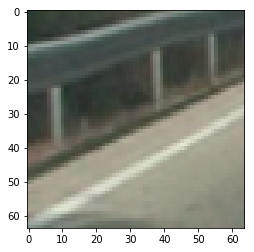

In [16]:
# 
# # Read in car and non-car images
# images = glob.glob('*.jpeg')
# cars = []
# notcars = []
# for image in images:
#     if 'image' in image or 'extra' in image:
#         notcars.append(image)
#     else:
#         cars.append(image)

# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 32
histbin = 32

print('running')
cars = all_veh
notcars = all_non_veh

# car_features = extract_features(cars, cspace='RGB', spatial_size=(spatial, spatial),
#                         hist_bins=histbin, hist_range=(0, 256))
# notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(spatial, spatial),
#                         hist_bins=histbin, hist_range=(0, 256))

# def extract_features_DELETEME(imgs, cspace='RGB', orient=9, 
#                         pix_per_cell=8, cell_per_block=2, hog_channel=0):
    
# car_features = extract_features_DELETEME(cars, cspace='RGB')
# notcar_features = extract_features_DELETEME(notcars, cspace='RGB')

global_colour_space = 'YCrCb'

print('extracting features')
car_features = extract_imgs_features(cars, color_space=global_colour_space, spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=False, hist_feat=False, hog_feat=True)
notcar_features = extract_imgs_features(notcars, color_space=global_colour_space, spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=False, hist_feat=False, hog_feat=True)
print('done extracting features')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# # Fit a per-column scaler
# X_scaler = StandardScaler().fit(X)
# # Apply the scaler to X
# scaled_X = X_scaler.transform(X)

print('features len: {}'.format(len(car_features)))
print('features shape: {}'.format(len(car_features[0].shape)))
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
# X_train, X_test, y_train, y_test = train_test_split(
#     scaled_X, y, test_size=0.2, random_state=rand_state)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('X_train len: {}' .format(len(X_train)))
print('X_test len: {}' .format(len(X_test)))
print('X_test len: {}' .format(len(X_test)))
print('y_test len: {}' .format(len(y_test)))


# Use a linear SVC 
print('creating svc')
svc = LinearSVC()
print('done creating svc')


print('done')

In [17]:
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

6.58 Seconds to train SVC...
Test Accuracy of SVC =  0.9564


In [18]:
n_predict = 10
print('My SVC predicts: \t', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: \t', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

My SVC predicts: 	 [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels: 	 [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.02607 Seconds to predict 10 labels with SVC


In [19]:
def save_model(filename):
    with open(filename, 'wb') as save_file:
        pickle.dump(
            {   'svc':svc, 
                # 'scaler': X_scaler,
                'orient': orient,
                'pix_per_cell': pix_per_cell,       
                'cell_per_block': cell_per_block,
                'spatial_size': spatial_size,
                'hist_bins': hist_bins,
            },
            save_file, pickle.HIGHEST_PROTOCOL)

In [20]:
save_model('svc_pickle.p')

In [21]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
        print('img_features len: {}' .format(len(img_features)))

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [22]:
# Start of the sliding window functioality

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [23]:
#load data from files

dist_pickle = pickle.load( open("./svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
# X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

In [24]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [25]:
# extracted the code to get the searchable portion of the image into its own meth
def get_image_to_search(full_img, ystart, ystop):
    img_tosearch = full_img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, cspace='RGB2YCrCb')
    # plt.imshow(ctrans_tosearch)
    return ctrans_tosearch

In [35]:
# 

img = mpimg.imread('./test_images/test1.jpg')
plt.imshow(img)
print('image shape: {}'.format(img.shape))
    
# ystart = 400
# ystop = 656
# scale = 1.5
# ctrans_tosearch = get_image_to_search(img, ystart, ystop)

image shape: (720, 1280, 3)


In [25]:
class Rect():
    def __init__(self, xbox_left, ytop_draw, win_draw):
        self.image_raw = False
        self.xbox_left = xbox_left
        self.ytop_draw = ytop_draw
        self.win_draw = win_draw

In [41]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    all_rect = []
    posi_rec = []
    negi_rec = []
    
    print('image shape: {}'.format(img.shape))
    
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    # 
    # ctrans_tosearch = get_image_to_search(img, ystart, ystop)
    # print('image shape: {}'.format(ctrans_tosearch.shape))
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, cspace=global_colour_space)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    print('nblocks_per_window: {}' .format(nblocks_per_window))
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 


            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            # print('hog_feat1 len: {}' .format(len(hog_feat1)))
            # print('hog_feat2 len: {}' .format(len(hog_feat2)))  
            # print('hog_feat3 len: {}' .format(len(hog_feat3)))
            # print('hog_features len: {}' .format(len(hog_features)))            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            # 
            # # Extract the image patch
            # subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            # 
            # # Get color features
            # spatial_features = bin_spatial(subimg, size=spatial_size)
            # hist_features = color_hist(subimg, nbins=hist_bins)
            # 
            # # Scale features and make a prediction
            # print('spatial_features len:{}' .format(len(spatial_features)))
            # print('hist_features len:{}' .format(len(hist_features)))
            # print('hog_features len:{}' .format(len(hog_features)))
            # print('spatial_features shape:{}' .format(spatial_features.shape))
            # print('hist_features shape:{}' .format(hist_features.shape))
            # print('hog_features shape:{}' .format(hog_features.shape))
            # # test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            # test_prediction = svc.predict(test_features)
            # test_prediction = svc.predict(hog_features)
            test_prediction = svc.predict(hog_feat1.reshape(1, -1))    
            
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            if test_prediction == 1:
                # xbox_left = np.int(xleft*scale)
                # ytop_draw = np.int(ytop*scale)
                # win_draw = np.int(window*scale)
                # cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                rect = Rect(xbox_left, ytop_draw, win_draw)
                posi_rec.append(rect)
            else:
                rect = Rect(xbox_left, ytop_draw, win_draw)
                negi_rec.append(rect)
                
    for rect in negi_rec:
        xbox_left = rect.xbox_left
        ytop_draw = rect.ytop_draw
        win_draw = rect.win_draw
        cv2.rectangle(draw_img ,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)            
                        
    for rect in posi_rec:
        xbox_left = rect.xbox_left
        ytop_draw = rect.ytop_draw
        win_draw = rect.win_draw
        cv2.rectangle(draw_img ,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)            
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 1
    
out_img = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

image shape: (720, 1280, 3)
nblocks_per_window: 7


C:\Users\georg\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
